In [3]:
#@title IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [5]:
# Deep Learning
import tensorflow as tf
from tensorflow import keras

In [6]:
#@title LOAD DATASET

# Load data
df = pd.read_csv('data.csv')

print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nDataset Info:")
print(df.info())
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum())


Total rows: 2098
Total columns: 2

Column names: ['label', 'data']

First 5 rows:
   label                                               data
0  anger  sok geura leungit atuh sia teh corona, matak g...
1  anger  Nu katoel katuhu nu nyerina kenca, goblog wasitna
2    joy  Bingah pisan patepang sareng pangerasa. Sing k...
3   fear  asa hariwang kieu.. lalakon hirup teh asa nyor...
4  anger  Orang mana sih anying, sampis pisan. Bunuh ae ...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2098 entries, 0 to 2097
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2098 non-null   object
 1   data    2098 non-null   object
dtypes: object(2)
memory usage: 32.9+ KB
None

Class distribution:
label
joy        539
sadness    530
anger      518
fear       511
Name: count, dtype: int64

Missing values:
label    0
data     0
dtype: int64


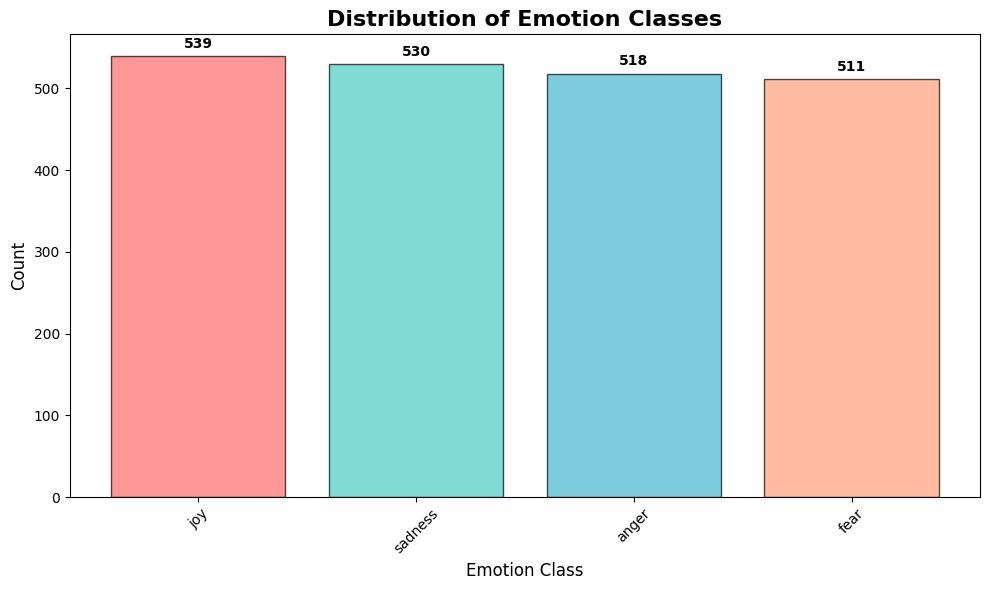


📊 Visualisasi 1: Class Distribution
Insight: Dataset memiliki 4 kelas emosi.
  - joy: 539 samples (25.69%)
  - sadness: 530 samples (25.26%)
  - anger: 518 samples (24.69%)
  - fear: 511 samples (24.36%)


In [7]:
#@title Exploratory Data Analysis 1 (EDA)

# 3.1 Class Distribution Visualization
plt.figure(figsize=(10, 6))
class_counts = df['label'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
plt.bar(class_counts.index, class_counts.values, color=colors, edgecolor='black', alpha=0.7)
plt.title('Distribution of Emotion Classes', fontsize=16, fontweight='bold')
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('eda_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualisasi 1: Class Distribution")
print(f"Insight: Dataset memiliki {len(class_counts)} kelas emosi.")
for label, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  - {label}: {count} samples ({percentage:.2f}%)")



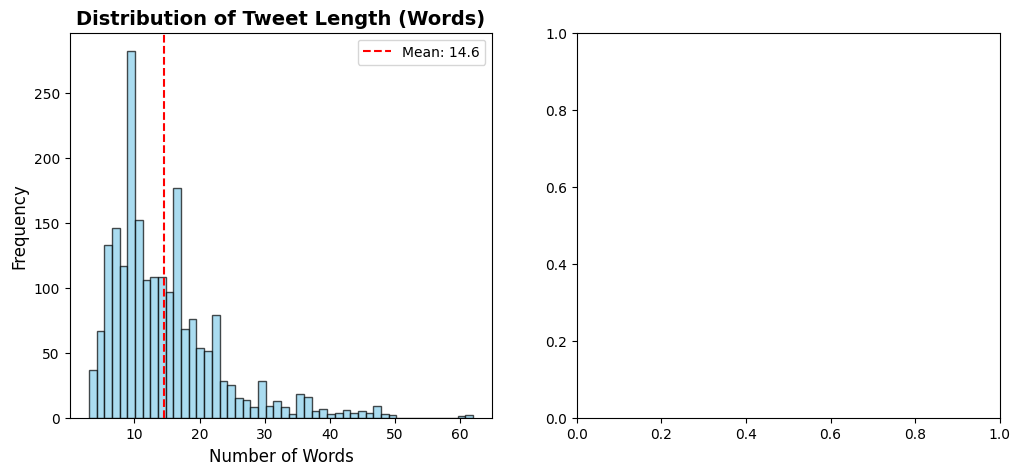

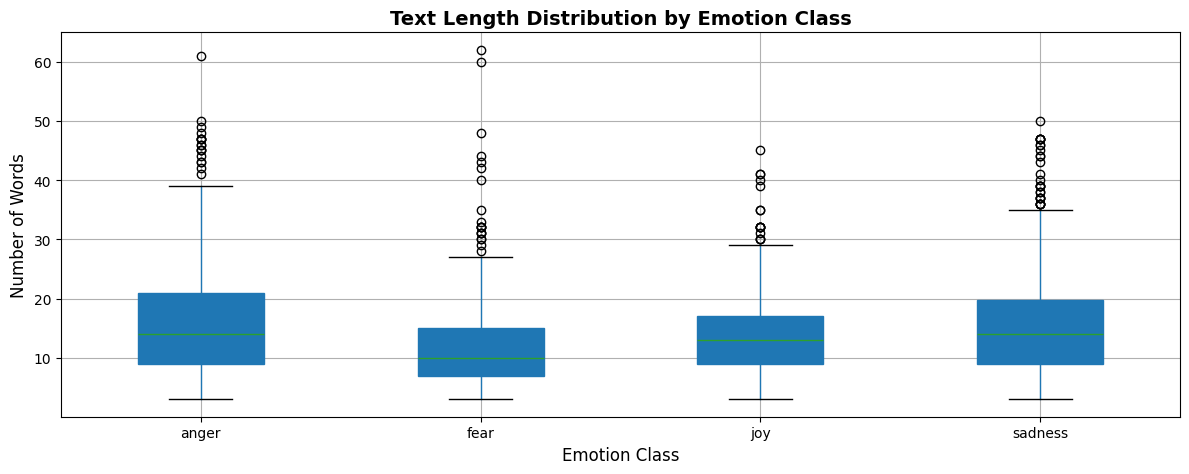


📊 Visualisasi 2: Text Length Distribution
  - Mean length: 14.57 words
  - Median length: 13.00 words
  - Min length: 3 words
  - Max length: 62 words
Insight: Memahami panjang teks membantu menentukan parameter model (max_length, etc.)


In [8]:
#@title Exploratory Data Analysis 2 (EDA)

# 3.2 Text Length Distribution
df['text_length'] = df['data'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Tweet Length (Words)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['text_length'].mean():.1f}")
plt.legend()

plt.subplot(1, 2, 2)
df.boxplot(column='text_length', by='label', figsize=(12, 5), patch_artist=True)
plt.title('Text Length Distribution by Emotion Class', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.xlabel('Emotion Class', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.tight_layout()
plt.savefig('eda_text_length.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualisasi 2: Text Length Distribution")
print(f"  - Mean length: {df['text_length'].mean():.2f} words")
print(f"  - Median length: {df['text_length'].median():.2f} words")
print(f"  - Min length: {df['text_length'].min()} words")
print(f"  - Max length: {df['text_length'].max()} words")
print("Insight: Memahami panjang teks membantu menentukan parameter model (max_length, etc.)")


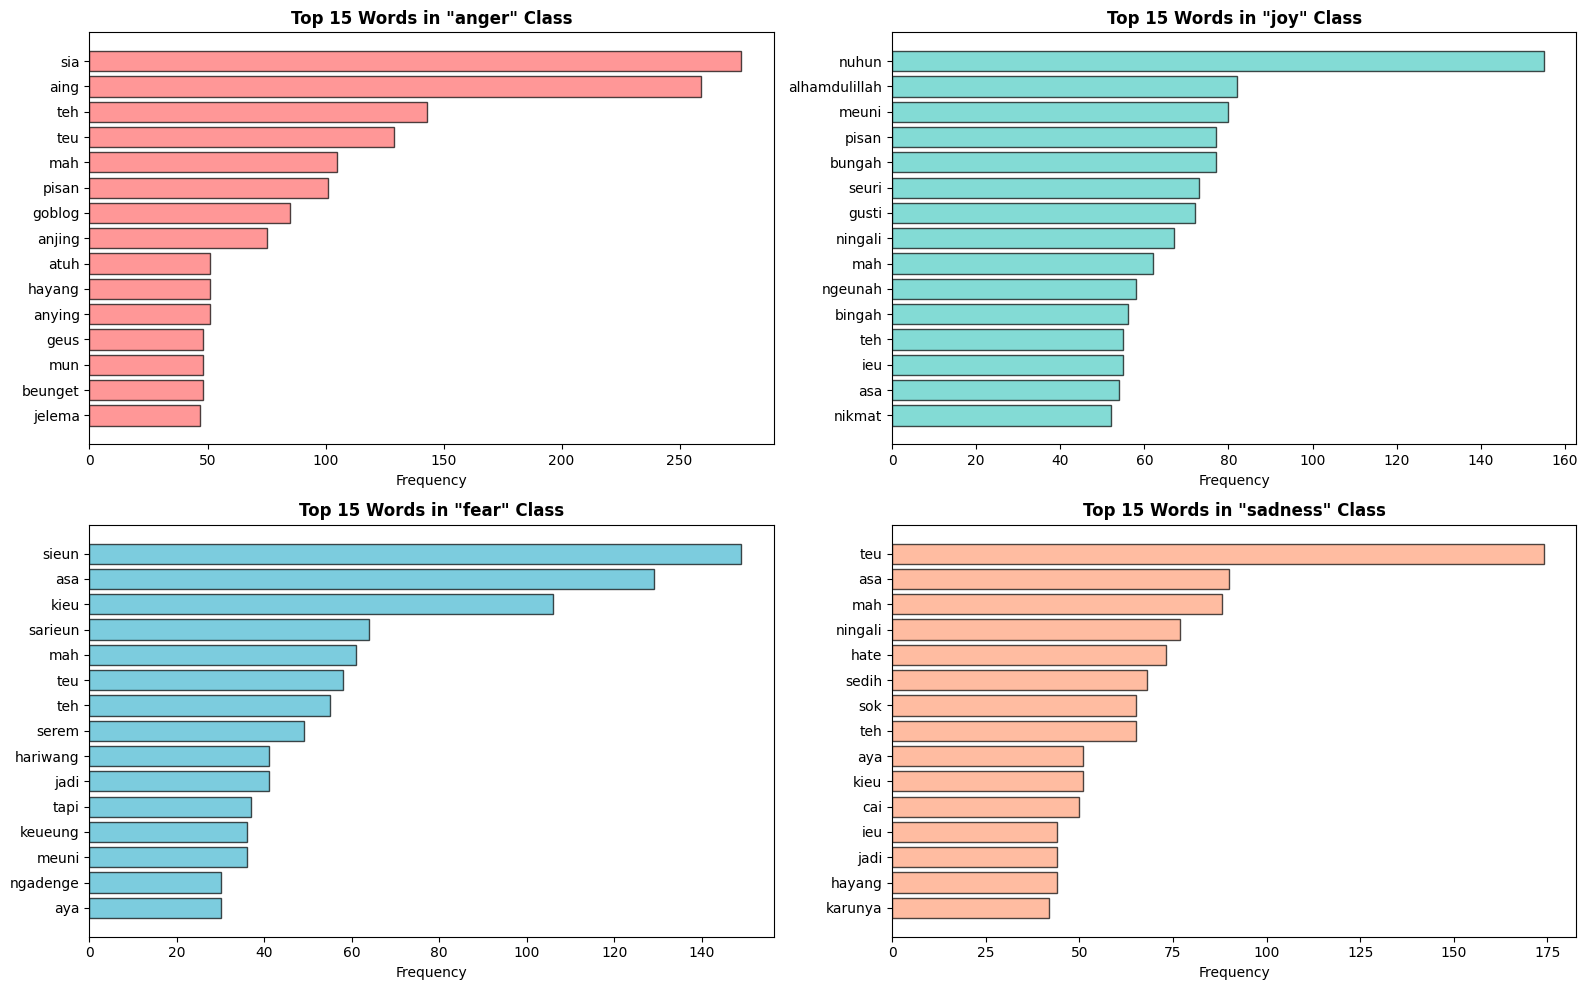


📊 Visualisasi 3: Most Common Words per Emotion Class
Insight: Kata-kata yang sering muncul dapat menjadi indikator kuat untuk klasifikasi emosi.


In [9]:
#@title Exploratory Data Analysis 3 (EDA)

# 3.3 Most Common Words per Class
from collections import Counter
import itertools

def get_top_words(texts, n=20):
    words = ' '.join(texts).lower().split()
    # Remove common punctuation
    words = [w for w in words if len(w) > 2 and w.isalpha()]
    return Counter(words).most_common(n)

plt.figure(figsize=(16, 10))
for idx, label in enumerate(df['label'].unique(), 1):
    texts = df[df['label'] == label]['data'].astype(str)
    top_words = get_top_words(texts, n=15)
    words, counts = zip(*top_words)

    plt.subplot(2, 2, idx)
    plt.barh(words, counts, color=colors[idx-1], alpha=0.7, edgecolor='black')
    plt.title(f'Top 15 Words in "{label}" Class', fontsize=12, fontweight='bold')
    plt.xlabel('Frequency', fontsize=10)
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('eda_top_words.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualisasi 3: Most Common Words per Emotion Class")
print("Insight: Kata-kata yang sering muncul dapat menjadi indikator kuat untuk klasifikasi emosi.")

In [10]:
#@title Data Preparation

# 4.1 Data Cleaning Function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Apply cleaning
print("\n🧹 Cleaning text data...")
df['cleaned_text'] = df['data'].apply(clean_text)

# Remove empty texts
original_len = len(df)
df = df[df['cleaned_text'].str.len() > 0]
print(f"Removed {original_len - len(df)} empty texts after cleaning")

# 4.2 Remove duplicates
duplicates = df.duplicated(subset=['cleaned_text']).sum()
print(f"\n🔍 Found {duplicates} duplicate texts")
if duplicates > 0:
    df = df.drop_duplicates(subset=['cleaned_text'])
    print(f"✅ Removed duplicates. New dataset size: {len(df)}")



🧹 Cleaning text data...
Removed 0 empty texts after cleaning

🔍 Found 20 duplicate texts
✅ Removed duplicates. New dataset size: 2078


In [11]:
# @title Train-Test Split

# Split data: 80% train, 20% test
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

print(f"Training set size: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())

Training set size: 1662 samples (80.0%)
Test set size: 416 samples (20.0%)

Class distribution in training set:
label
joy        425
sadness    419
anger      412
fear       406
Name: count, dtype: int64

Class distribution in test set:
label
joy        107
sadness    105
anger      103
fear       101
Name: count, dtype: int64



 Creating TF-IDF features...
TF-IDF feature shape: (1662, 3448)

🚀 Training Logistic Regression...
✅ Training completed in 0.80 seconds

MODEL 1 EVALUATION RESULTS
Accuracy : 0.9423
Precision: 0.9432
Recall   : 0.9423
F1-Score : 0.9423

Detailed Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.98      0.94       103
        fear       0.96      0.92      0.94       101
         joy       0.96      0.94      0.95       107
     sadness       0.94      0.92      0.93       105

    accuracy                           0.94       416
   macro avg       0.94      0.94      0.94       416
weighted avg       0.94      0.94      0.94       416



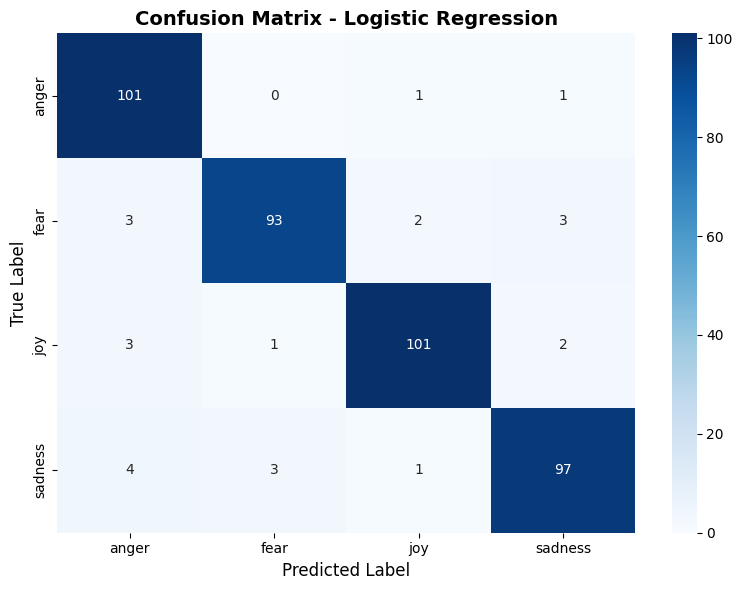

In [12]:
# @title MODEL 1 - BASELINE: LOGISTIC REGRESSION

# TF-IDF Vectorization
print("\n Creating TF-IDF features...")
tfidf = TfidfVectorizer(
    max_features=5000,  # Use top 5000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2  # Minimum document frequency
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

# Train Logistic Regression
print("\n🚀 Training Logistic Regression...")
import time
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=500,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42
)
lr_model.fit(X_train_tfidf, y_train)

lr_train_time = time.time() - start_time
print(f"✅ Training completed in {lr_train_time:.2f} seconds")

# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluation
print("\n" + "="*50)
print("MODEL 1 EVALUATION RESULTS")
print("="*50)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Accuracy : {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall   : {lr_recall:.4f}")
print(f"F1-Score : {lr_f1:.4f}")
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('cm_logistic_regression.png', dpi=300, bbox_inches='tight')
plt.show()


In [16]:
# Save Model 1
import pickle
print("\n💾 Saving Logistic Regression model...")
with open('model_baseline.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✅ Model saved as 'model_baseline.pkl'")

# Save TF-IDF vectorizer (needed for inference)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
print("✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'")


💾 Saving Logistic Regression model...
✅ Model saved as 'model_baseline.pkl'
✅ TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'



MODEL 2 EVALUATION RESULTS
Accuracy : 0.9038
Precision: 0.9054
Recall   : 0.9038
F1-Score : 0.9038

Detailed Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.95      0.92       103
        fear       0.92      0.92      0.92       101
         joy       0.95      0.86      0.90       107
     sadness       0.86      0.89      0.87       105

    accuracy                           0.90       416
   macro avg       0.91      0.90      0.90       416
weighted avg       0.91      0.90      0.90       416



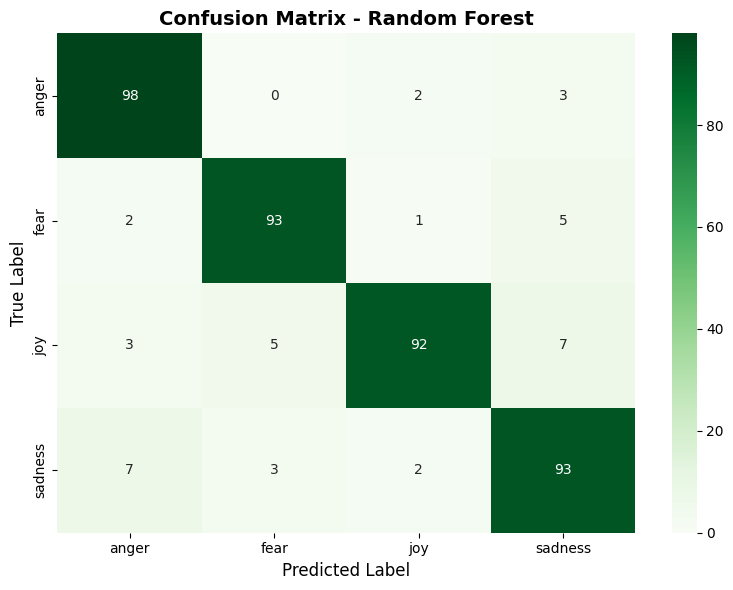


📊 Top 20 Most Important Features:


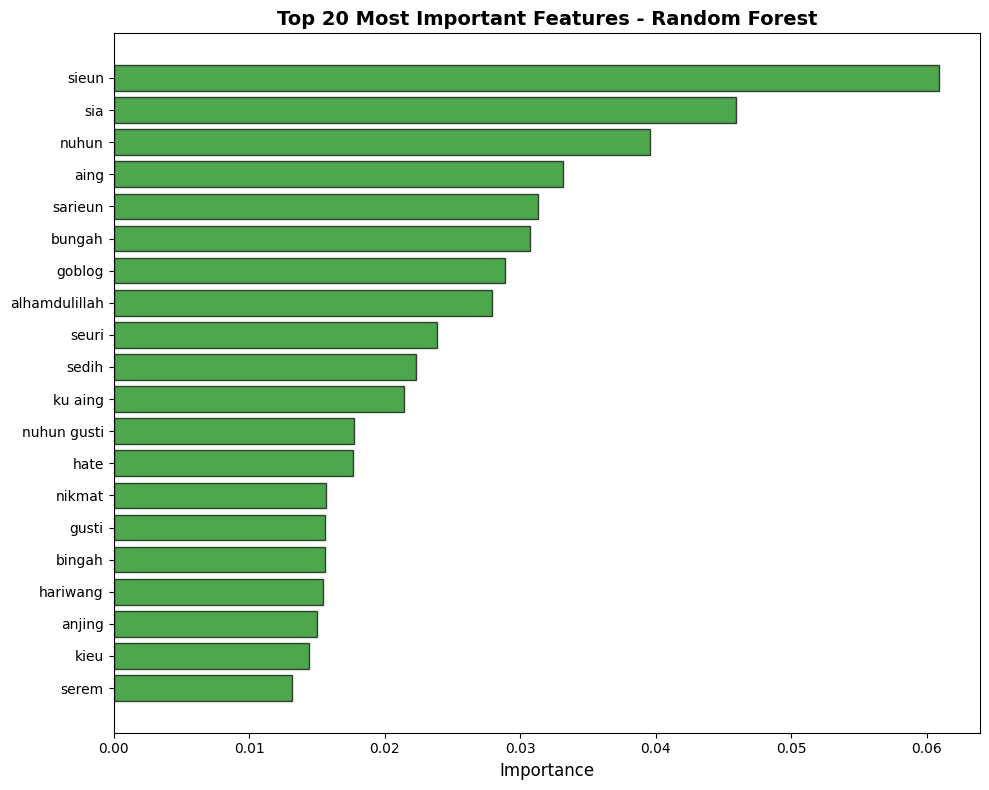

In [13]:
# @title MODEL 2 - ADVANCED: RANDOM FOREST + TF-IDF

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation
print("\n" + "="*50)
print("MODEL 2 EVALUATION RESULTS")
print("="*50)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Accuracy : {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall   : {rf_recall:.4f}")
print(f"F1-Score : {rf_f1:.4f}")
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('cm_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance
print("\n📊 Top 20 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': tfidf.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'],
         color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# Save Model 2
print("\n💾 Saving Random Forest model...")
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✅ Model saved as 'model_rf.pkl'")


💾 Saving Random Forest model...
✅ Model saved as 'model_rf.pkl'


Training sequences shape: (1662, 100)
Test sequences shape: (416, 100)
Number of classes: 4
Classes: ['anger' 'fear' 'joy' 'sadness']

🏗️ Building LSTM model...

📋 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


🚀 Training LSTM model...
Epochs: 30, Batch size: 32
Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 226ms/step - accuracy: 0.2708 - loss: 1.3842 - val_accuracy: 0.5375 - val_loss: 1.3073 - learning_rate: 0.0010
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.4669 - loss: 1.1963 - val_accuracy: 0.6877 - val_loss: 0.9131 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.7352 - loss: 0.7120 - val_accuracy: 0.8799 - val_loss: 0.3563 - learning_rate: 0.0010
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9787 - loss: 0.1379 - val_accuracy: 0.9039 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9984 - loss: 0.0337 - val_accuracy: 0.9099 - val_loss: 0.3848 - learning_rate: 0.0010
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.9984 - loss: 0.0198 - val_accuracy: 0.9249 - val_loss: 0.4277 - learning_rate: 0.0010
Epoch 7/30
42/42 ━━━━━━━━━━━━━

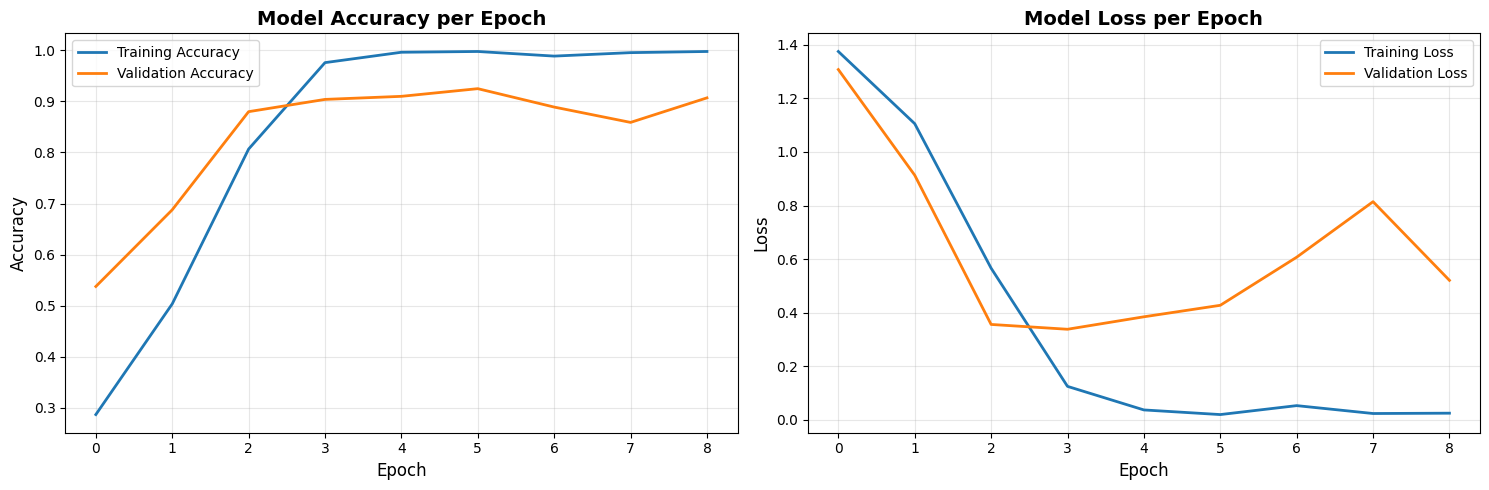


MODEL 3 EVALUATION RESULTS
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Accuracy : 0.8966
Precision: 0.8979
Recall   : 0.8966
F1-Score : 0.8964

Detailed Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.94      0.91       103
        fear       0.92      0.84      0.88       101
         joy       0.92      0.92      0.92       107
     sadness       0.87      0.89      0.88       105

    accuracy                           0.90       416
   macro avg       0.90      0.90      0.90       416
weighted avg       0.90      0.90      0.90       416



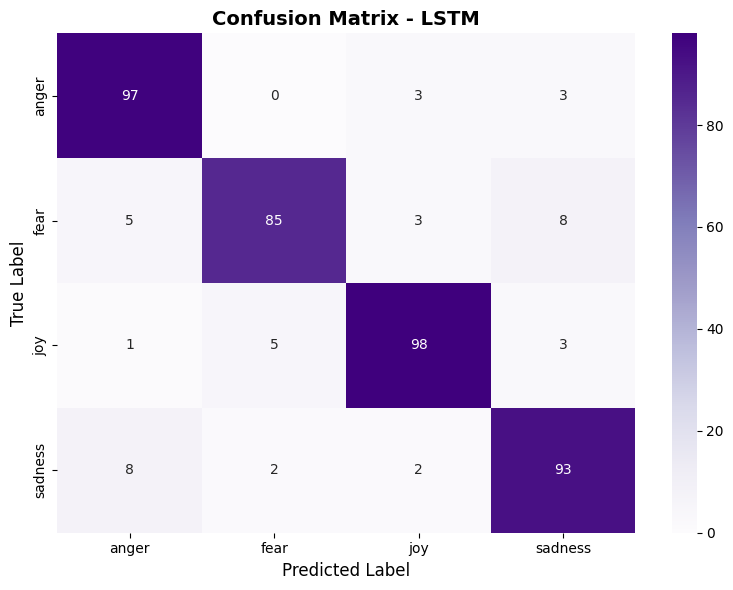


💾 Saving LSTM model and dependencies...
✅ LSTM model saved as 'model_lstm.h5'


In [19]:
# @title MODEL 3 - DEEP LEARNING: LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 100  # Maximum sequence length
EMBEDDING_DIM = 128
LSTM_UNITS = 64
EPOCHS = 30
BATCH_SIZE = 32

# Tokenize
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_pad.shape}")
print(f"Test sequences shape: {X_test_pad.shape}")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {le.classes_}")

# Convert to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_encoded, num_classes)

# 8.2 Build LSTM Model
print("\n🏗️ Building LSTM model...")

lstm_model = Sequential([
    # Embedding layer
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),

    # Bidirectional LSTM layers
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(LSTM_UNITS // 2)),
    Dropout(0.3),

    # Dense layers
    Dense(64, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📋 Model Architecture:")
lstm_model.summary()

# 8.3 Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# 8.4 Train Model
print("\n🚀 Training LSTM model...")
print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
start_time = time.time()

history = lstm_model.fit(
    X_train_pad, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

lstm_train_time = time.time() - start_time
print(f"\n✅ Training completed in {lstm_train_time/60:.2f} minutes")

# 8.5 Training History Visualization
print("\n📊 Plotting training history...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy per Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss per Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# 8.6 Evaluate on Test Set
print("\n" + "="*50)
print("MODEL 3 EVALUATION RESULTS")
print("="*50)

# Predictions
y_pred_lstm_probs = lstm_model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_probs, axis=1)

# Metrics
lstm_accuracy = accuracy_score(y_test_encoded, y_pred_lstm)
lstm_precision = precision_score(y_test_encoded, y_pred_lstm, average='weighted')
lstm_recall = recall_score(y_test_encoded, y_pred_lstm, average='weighted')
lstm_f1 = f1_score(y_test_encoded, y_pred_lstm, average='weighted')

print(f"Accuracy : {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall   : {lstm_recall:.4f}")
print(f"F1-Score : {lstm_f1:.4f}")
print(f"\nDetailed Classification Report:")
print(classification_report(y_test_encoded, y_pred_lstm, target_names=le.classes_))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test_encoded, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - LSTM', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('cm_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

# Save Model 3
print("\n💾 Saving LSTM model and dependencies...")
lstm_model.save('model_lstm.h5')
print("✅ LSTM model saved as 'model_lstm.h5'")

In [ ]:
# @title MODEL COMPARISON

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LSTM'],
    'Accuracy': [lr_accuracy, rf_accuracy, lstm_accuracy],
    'Precision': [lr_precision, rf_precision, lstm_precision],
    'Recall': [lr_recall, rf_recall, lstm_recall],
    'F1-Score': [lr_f1, rf_f1, lstm_f1],
    'Training Time (s)': [lr_train_time, rf_train_time, lstm_train_time]
})

print("\n📊 Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, [lr_accuracy, lr_precision, lr_recall, lr_f1],
            width, label='Logistic Regression', color='#FF6B6B', alpha=0.8)
axes[0].bar(x, [rf_accuracy, rf_precision, rf_recall, rf_f1],
            width, label='Random Forest', color='#4ECDC4', alpha=0.8)
axes[0].bar(x + width, [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1],
            width, label='LSTM', color='#9B59B6', alpha=0.8)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Training time comparison
axes[1].bar(comparison_df['Model'], comparison_df['Training Time (s)'],
            color=['#FF6B6B', '#4ECDC4', '#9B59B6'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[1].text(i, v + 5, f'{v:.1f}s', ha='center', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()